In [22]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['axes.titlesize'] = 5
from cellpose import utils, io

(264, 796)


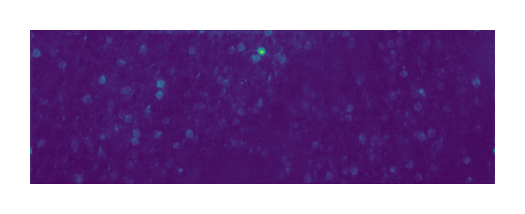

In [7]:
# # I will download images from website
# urls = ['http://www.cellpose.org/static/images/img02.png',
#         'http://www.cellpose.org/static/images/img03.png',
#         'http://www.cellpose.org/static/images/img05.png']
# files = []
# for url in urls:
#     parts = urlparse(url)
#     filename = os.path.basename(parts.path)
#     if not os.path.exists(filename):
#         sys.stderr.write('Downloading: "{}" to {}\n'.format(url, filename))
#         utils.download_url_to_file(url, filename)
#     files.append(filename)

# REPLACE FILES WITH YOUR IMAGE PATHS
files = ['stim_resp_gauss_cellpose.tif']

# view 1 image
img = io.imread(files[-1])
print(img.shape)

plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

In [11]:
# RUN CELLPOSE

from cellpose import models, io

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=False, model_type='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
channels = [[0,0]]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
# channels = [[2,3], [0,0], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images
diameter = 15

# you can run all in a list e.g.
# >>> imgs = [io.imread(filename) in for filename in files]
# >>> masks, flows, styles, diams = model.eval(imgs, diameter=None, channels=channels)
# >>> io.masks_flows_to_seg(imgs, masks, flows, diams, files, channels)
# >>> io.save_to_png(imgs, masks, flows, files)

# or in a loop
for chan, filename in zip(channels, files):
    img = io.imread(filename)
    masks, flows, styles, diams = model.eval(img, diameter=None, channels=chan)

    # save results so you can load in gui
    io.masks_flows_to_seg(img, masks, flows, diams, filename, chan)

    # save results as png
    io.save_to_png(img, masks, flows, filename)

In [20]:
def show_segmentation_LL(fig, img, maski, flowi, channels=[0,0], file_name=None):
    """ plot segmentation results (like on website)
    
    Can save each panel of figure with file_name option. Use channels option if
    img input is not an RGB image with 3 channels.
    
    Parameters
    -------------

    fig: matplotlib.pyplot.figure
        figure in which to make plot

    img: 2D or 3D array
        image input into cellpose

    maski: int, 2D array
        for image k, masks[k] output from Cellpose.eval, where 0=NO masks; 1,2,...=mask labels

    flowi: int, 2D array 
        for image k, flows[k][0] output from Cellpose.eval (RGB of flows)

    channels: list of int (optional, default [0,0])
        channels used to run Cellpose, no need to use if image is RGB

    file_name: str (optional, default None)
        file name of image, if file_name is not None, figure panels are saved
        
    seg_norm: bool (optional, default False)
        improve cell visibility under labels
        

    """
    from cellpose.plot import image_to_rgb, mask_overlay

    ax = fig.add_subplot(4,1,1)
    img0 = img.copy()

    if img0.shape[0] < 4:
        img0 = np.transpose(img0, (1,2,0))
    if img0.shape[-1] < 3 or img0.ndim < 3:
        img0 = image_to_rgb(img0, channels=channels)
    else:
        if img0.max()<=50.0:
            img0 = np.uint8(np.clip(img0*255, 0, 1))
    ax.imshow(img0)
    ax.set_title('original image')
    ax.axis('off')

    outlines = utils.masks_to_outlines(maski)

    overlay = mask_overlay(img0, maski)

    ax = fig.add_subplot(4,1,2)
    outX, outY = np.nonzero(outlines)
    imgout= img0.copy()
    imgout[outX, outY] = np.array([255,0,0]) # pure red

    ax.imshow(imgout)
    ax.set_title('predicted outlines')
    ax.axis('off')

    ax = fig.add_subplot(4,1,3)
    ax.imshow(overlay)
    ax.set_title('predicted masks')
    ax.axis('off')

    ax = fig.add_subplot(4,1,4)
    ax.imshow(flowi)
    ax.set_title('predicted cell pose')
    ax.axis('off')

    # if file_name is not None:
    #     save_path = os.path.splitext(file_name)[0]
    #     io.imsave(save_path + '_overlay.jpg', overlay)
    #     io.imsave(save_path + '_outlines.jpg', imgout)
    #     io.imsave(save_path + '_flows.jpg', flowi)

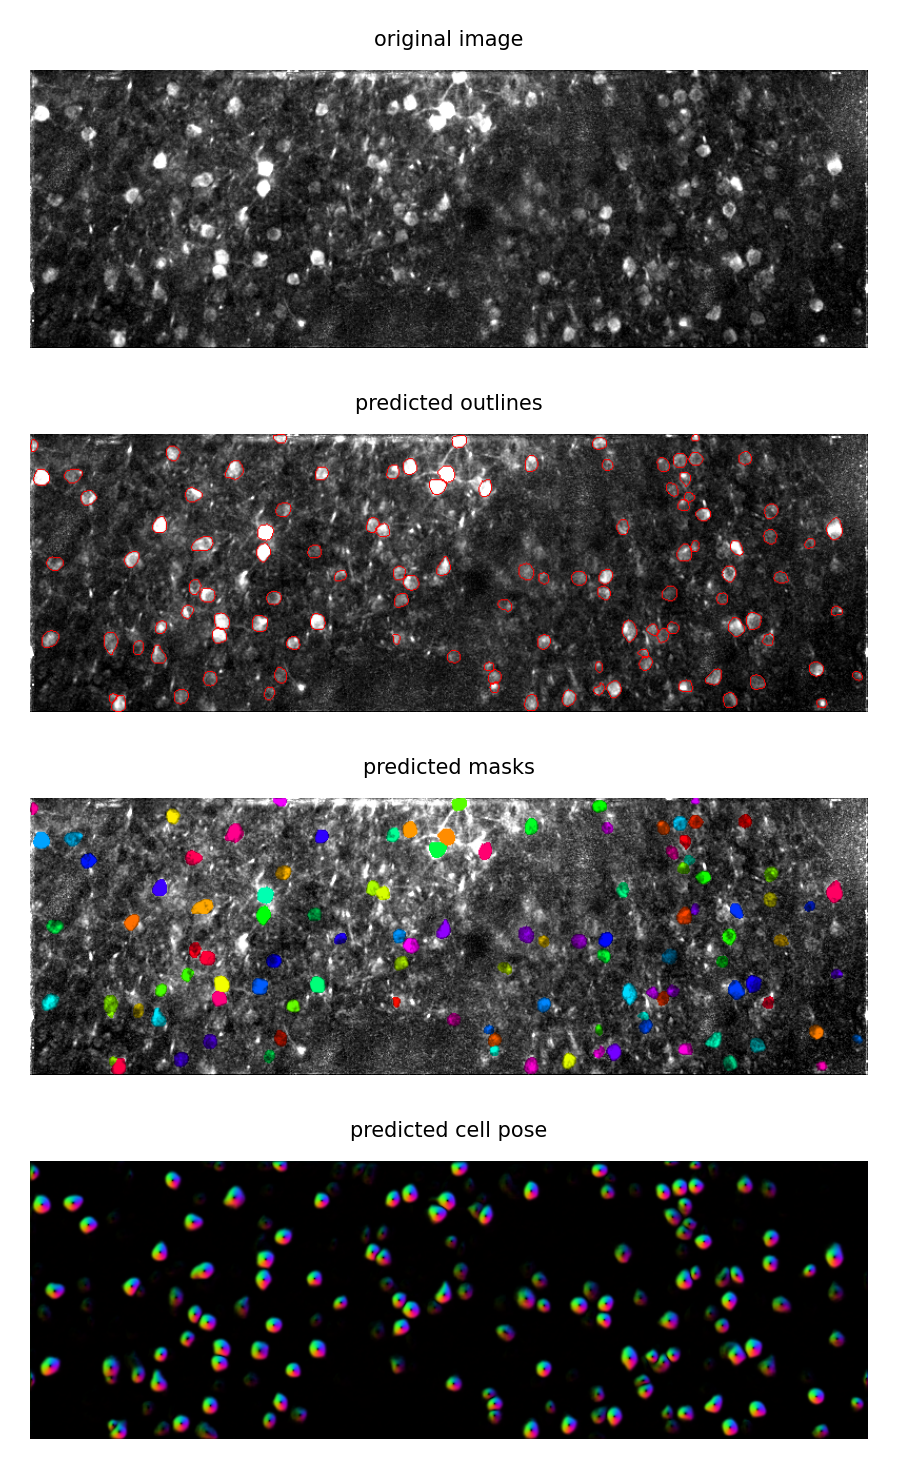

In [23]:
# DISPLAY RESULTS
from cellpose import plot

fig = plt.figure(figsize=(12,5))
show_segmentation_LL(fig, img, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()
# plt.savefig("cellpose.pdf", bbox_inches='tight')